In [2]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [3]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])

    return right, left

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.8:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

In [4]:
for e in range(1,17):
    exec(f'e{e} = pd.read_csv("../raw_data/AM/E2/xy_hc_fai_tstp_E2_{e}_AM.csv")')

In [19]:
e13

,X_coord,Y_coord,heading_direction,cumulative_direction,beat_freq,beat_amp,tail_move?,timestamp,contrast_level,flow_direction
0,812.0591,873.3182,2.660647,-2.660647,130.000000,0.854981,True,347,1.0,2
1,812.0075,873.2372,2.665962,-2.665962,43.333333,6.955101,True,351,1.0,2
2,812.0247,873.2972,2.662566,-2.662566,43.333333,6.955101,True,354,1.0,2
3,811.6394,873.4212,2.691530,-2.691530,43.333333,6.955101,True,357,1.0,2
4,811.5469,873.3802,2.696032,-2.696032,43.333333,6.955101,True,361,1.0,2
...,...,...,...,...,...,...,...,...,...,...
217178,NaN,NaN,NaN,NaN,0.000000,0.000000,False,416,0.3,2
217179,NaN,NaN,NaN,NaN,0.000000,0.000000,False,420,0.3,2
217180,NaN,NaN,NaN,NaN,0.000000,0.000000,False,423,0.3,2
217181,NaN,NaN,NaN,NaN,0.000000,0.000000,False,427,0.3,2


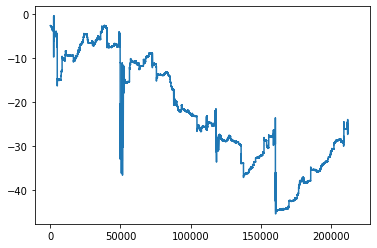

In [14]:
plt.plot(e13['cumulative_direction'])

In [7]:
for e in range(1,17):
    exec(f'Le{e},Re{e} = divide_data_by_flow_direction(e{e})')

In [8]:
for flow in ['R','L']:
    for e in range(1,17):
        exec(f'{flow}e{e}C_0, {flow}e{e}C_01, {flow}e{e}C_1, {flow}e{e}C_2, {flow}e{e}C_3, \
            {flow}e{e}C_5, {flow}e{e}C_7, {flow}e{e}C_10 = divide_data_by_contrast({flow}e{e})')

In [9]:
for flow in ['R','L']:
    for contrast in ['01','1','2','3','5','7','10']:
        for e in range(1,17):
            exec(f'{flow}e{e}C_{contrast} = omr_preprocess({flow}e{e}C_{contrast})')

### Fish with algorithm malfunction or many null values or no data at all:
#### Get rid of fish 10 ????
#### Right Flows
- Re8C_01 --> big jumps


- Re4C_1 --> big jumps
- Re10C_1 --> NO DATA 


- Re5C_2 --> NULLS
- Re7C_2 --> big jumps (only at the end)
- Re10C_2 --> impossible cumulative heading 


- Re2C_3 --> big jumps (only at the beginning)
- Re9C_3 --> no movement and the massive jumps


- Re4C_5 --> double check this one (jumps maybe too big?)
- Re6C_5 --> 1 big jump
- Re10C_5 --> NO DATA 
- Re11C_5 --> NULLS
- Re14C_5 --> 1 big jump


- Re5C_7 --> NO DATA 
- Re7C_7 --> 1 big jump
- Re13C_7 --> absolutely crazy (cumulative -20 radians within 30secs)
- Re14C_7 --> 1 big jump


- Re1C_10 --> 1 big jump
- Re7C_10 --> double check this one
- Re8C_10 --> 2 big jumps
- Re10C_10 --> double check
- Re12C_10 --> big jumps?

#### Left Flows:
- Le1C_01 --> NULLS
- Le11C_01 --> big jumps


- Le13C_1 --> big jumps (only at the beginning)
- Le14C_1 --> 1 big jump


- Le6C_2 --> 2 big jumps
- Le9C_2 --> 1 big jump
- Le14C_2 --> 2 big jumps


- Le2C_3 --> 1 big jump
- Le7C_3 --> NULLS
- Le10C_3 --> NO DATA 
- Le11C_3 --> big jumps 
- Le13C_3 --> double check
- Le14C_3 --> big jumps


- Le4C_5 --> double check
- Le8C_5 --> 1 big jump
- Le10C_5 --> double check (-20 radians??)
- Le12C_5 --> 30 radian jump at the end
- Le14C_5 --> 2 big jumps


- Le6C_7 --> 1 radian jumps?
- Le14C_7 --> NULLS
- Le15C_7 --> 1 big jump


- Le4C_10 --> big jumps
- Le14C_10 --> 2 big jumps

In [ ]:
# exclusion zone --> reject measurements 10% outside center, filter the input data, if head is outside the inner circe, 
# make the change in cumulative angle 0 

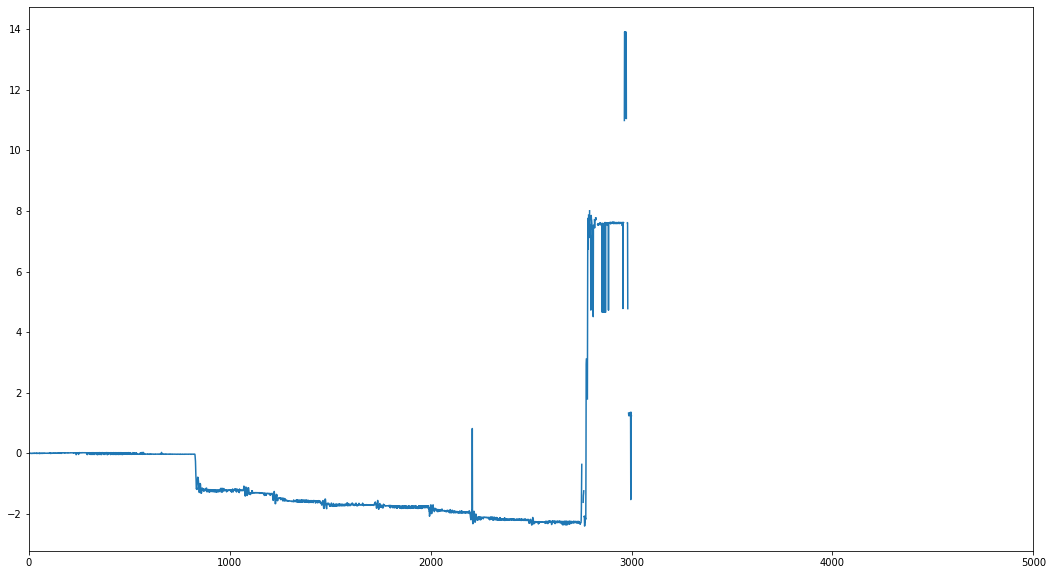

In [18]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.plot(Le7C_3[:,4])
plt.xlim(0,5000)
plt.show()

In [290]:
comb_LeC_01 = combine_fish_data(Le2C_01,Le3C_01,Le4C_01,Le5C_01,Le6C_01,Le7C_01,Le8C_01,Le9C_01,Le10C_01,Le11C_01,\
                                Le12C_01,Le13C_01,Le14C_01,Le15C_01,Le16C_01)
comb_LeC_1 = combine_fish_data(Le1C_1,Le2C_1,Le3C_1,Le4C_1,Le5C_1,Le6C_1,Le7C_1,Le8C_1,Le9C_1,Le10C_1,Le11C_1,\
                               Le12C_1,Le13C_1,Le14C_1,Le15C_1,Le16C_1)
comb_LeC_2 = combine_fish_data(Le1C_2,Le2C_2,Le3C_2,Le4C_2,Le5C_2,Le6C_2,Le7C_2,Le8C_2,Le9C_2,Le10C_2,Le11C_2,\
                               Le12C_2,Le13C_2,Le14C_2,Le15C_2,Le16C_2)
comb_LeC_3 = combine_fish_data(Le1C_3,Le2C_3,Le3C_3,Le4C_3,Le5C_3,Le6C_3,Le8C_3,Le9C_3,Le11C_3,Le12C_3,Le13C_3,\
                               Le14C_3,Le15C_3,Le16C_3)
comb_LeC_5 = combine_fish_data(Le1C_5,Le2C_5,Le3C_5,Le4C_5,Le5C_5,Le6C_5,Le7C_5,Le8C_5,Le9C_5,Le10C_5,Le11C_5,\
                               Le12C_5,Le13C_5,Le14C_5,Le15C_5,Le16C_5)
comb_LeC_7 = combine_fish_data(Le1C_7,Le2C_7,Le3C_7,Le4C_7,Le5C_7,Le6C_7,Le7C_7,Le8C_7,Le9C_7,Le10C_7,Le11C_7,\
                               Le12C_7,Le13C_7,Le15C_7,Le16C_7)
comb_LeC_10 = combine_fish_data(Le1C_10,Le2C_10,Le3C_10,Le4C_10,Le5C_10,Le6C_10,Le7C_10,Le8C_10,Le9C_10,Le10C_10,\
                                Le11C_10,Le12C_10,Le13C_10,Le14C_10,Le15C_10,Le16C_10)

comb_ReC_01 = combine_fish_data(Re1C_01,Re2C_01,Re3C_01,Re4C_01,Re5C_01,Re6C_01,Re7C_01,Re8C_01,Re9C_01,Re10C_01,\
                                Re11C_01,Re12C_01,Re13C_01,Re14C_01,Re15C_01,Re16C_01)
comb_ReC_1 = combine_fish_data(Re1C_1,Re2C_1,Re3C_1,Re4C_1,Re5C_1,Re6C_1,Re7C_1,Re8C_1,Re9C_1,\
                                Re11C_1,Re12C_1,Re13C_1,Re14C_1,Re15C_1,Re16C_1)
comb_ReC_2 = combine_fish_data(Re1C_2,Re2C_2,Re3C_2,Re4C_2,Re6C_2,Re8C_2,Re9C_2,\
                                Re11C_2,Re12C_2,Re13C_2,Re14C_2,Re15C_2,Re16C_2)
comb_ReC_3 = combine_fish_data(Re1C_3,Re2C_3,Re3C_3,Re4C_3,Re5C_3,Re6C_3,Re7C_3,Re8C_3,Re9C_3,Re10C_3,\
                                Re11C_3,Re12C_3,Re13C_3,Re14C_3,Re15C_3,Re16C_3)
comb_ReC_5 = combine_fish_data(Re1C_5,Re2C_5,Re3C_5,Re4C_5,Re5C_5,Re6C_5,Re7C_5,Re8C_5,Re9C_5,\
                                Re12C_5,Re13C_5,Re14C_5,Re15C_5,Re16C_5)
comb_ReC_7 = combine_fish_data(Re1C_7,Re2C_7,Re3C_7,Re4C_7,Re6C_7,Re7C_7,Re8C_7,Re9C_7,Re10C_7,\
                                Re11C_7,Re12C_7,Re14C_7,Re15C_7,Re16C_7)
comb_ReC_10 = combine_fish_data(Re1C_10,Re2C_10,Re3C_10,Re4C_10,Re5C_10,Re6C_10,Re7C_10,Re8C_10,Re9C_10,Re10C_10,\
                                Re11C_10,Re12C_10,Re13C_10,Re14C_10,Re15C_10,Re16C_10)

In [291]:
for flow in ['R','L']:
    for contrast in ['01','1','2','3','5','7','10']:
        exec(f'{flow}e_C_{contrast}_cum_mean = np.nanmean(comb_{flow}eC_{contrast}[:,-1,4])')

<BarContainer object of 7 artists>

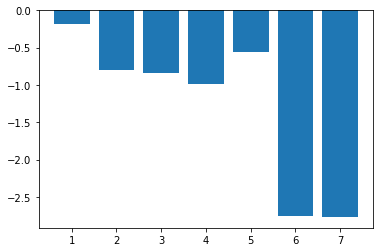

In [292]:
plt.bar([1,2,3,4,5,6,7],[Le_C_01_cum_mean,Le_C_1_cum_mean,Le_C_2_cum_mean,Le_C_3_cum_mean,\
                        Le_C_5_cum_mean,Le_C_7_cum_mean,Le_C_10_cum_mean])

<BarContainer object of 7 artists>

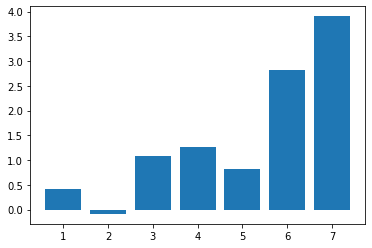

In [293]:
plt.bar([1,2,3,4,5,6,7],[Re_C_01_cum_mean,Re_C_1_cum_mean,Re_C_2_cum_mean,Re_C_3_cum_mean,\
                        Re_C_5_cum_mean,Re_C_7_cum_mean,Re_C_10_cum_mean])

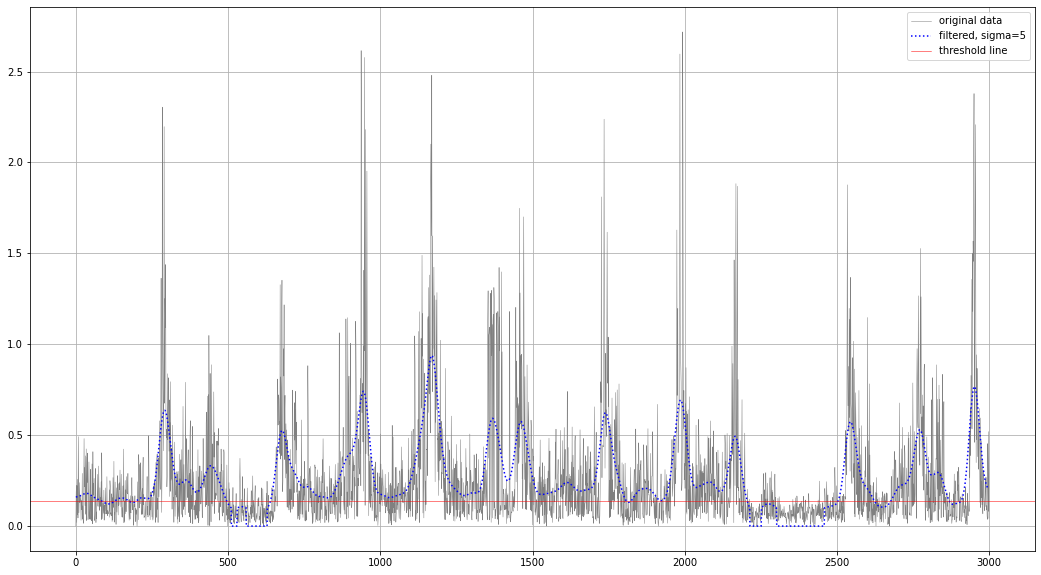

Threshold:  0.13545280890954786
Number of Peaks:  23


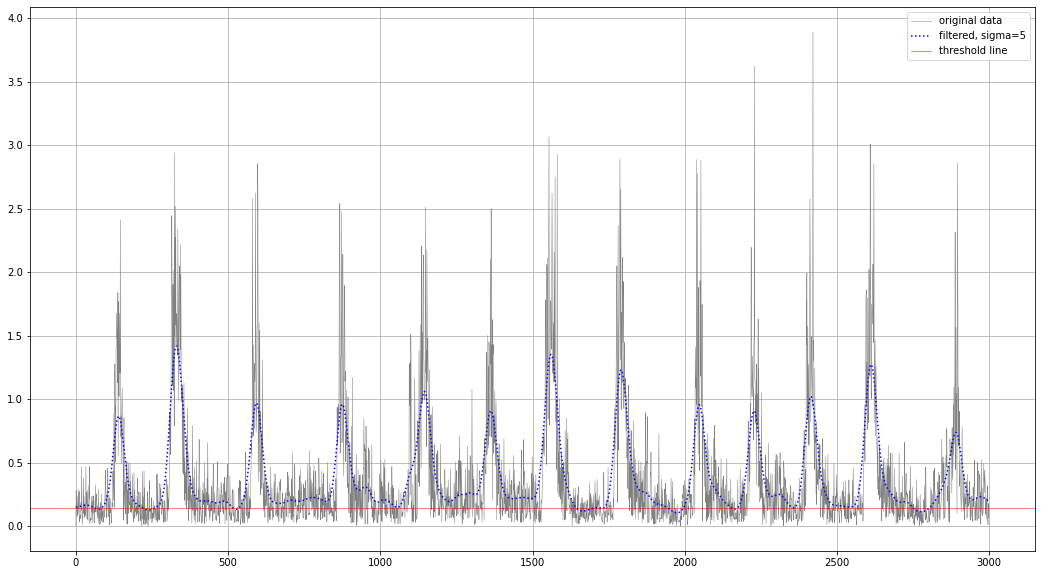

Threshold:  0.14489752540520234
Number of Peaks:  26


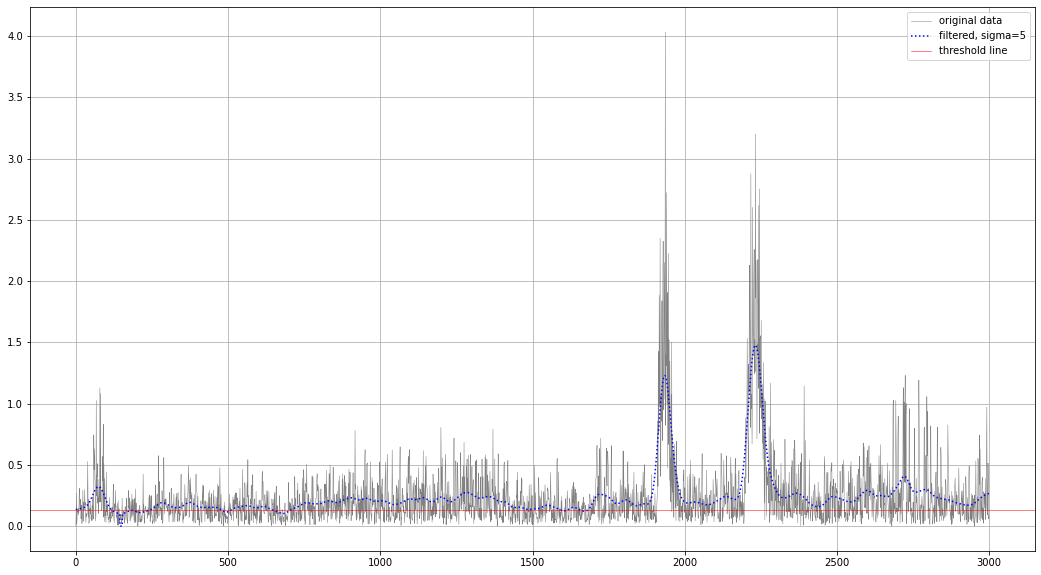

Threshold:  0.1350539166320916
Number of Peaks:  34


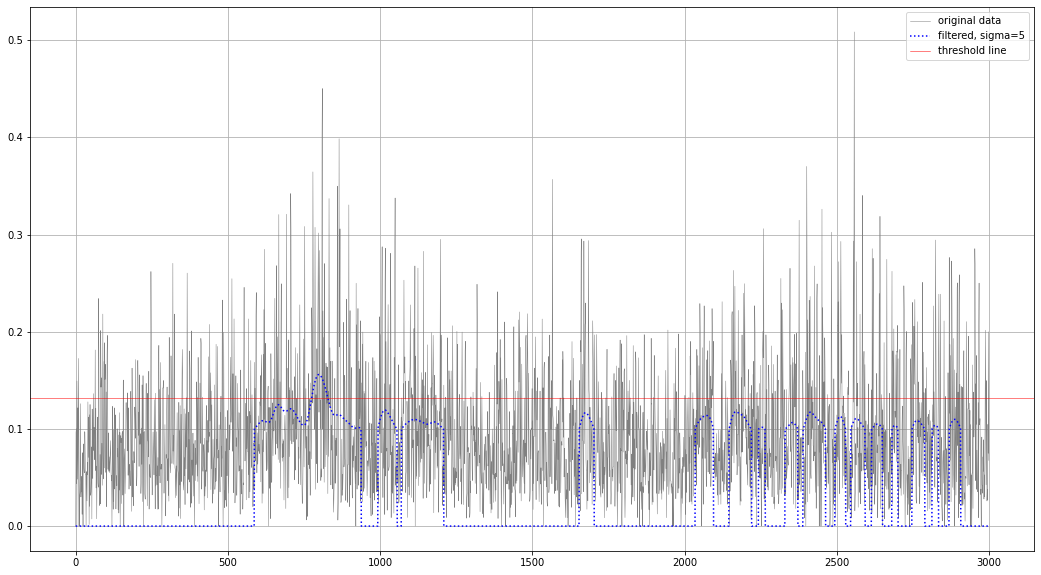

Threshold:  0.13203126126832776
Number of Peaks:  1


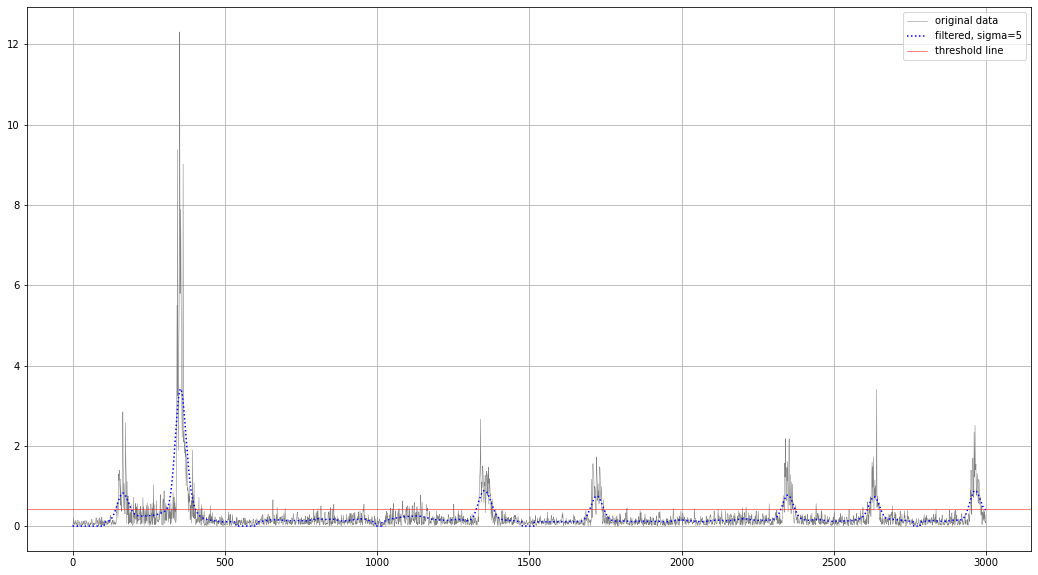

Threshold:  0.42198850316929987
Number of Peaks:  7


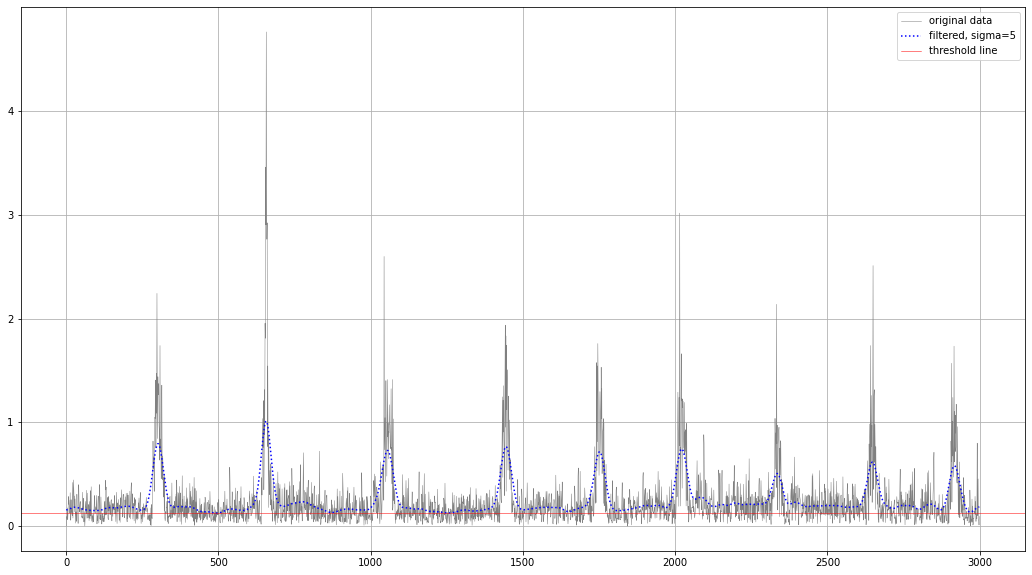

Threshold:  0.12598232574712234
Number of Peaks:  36


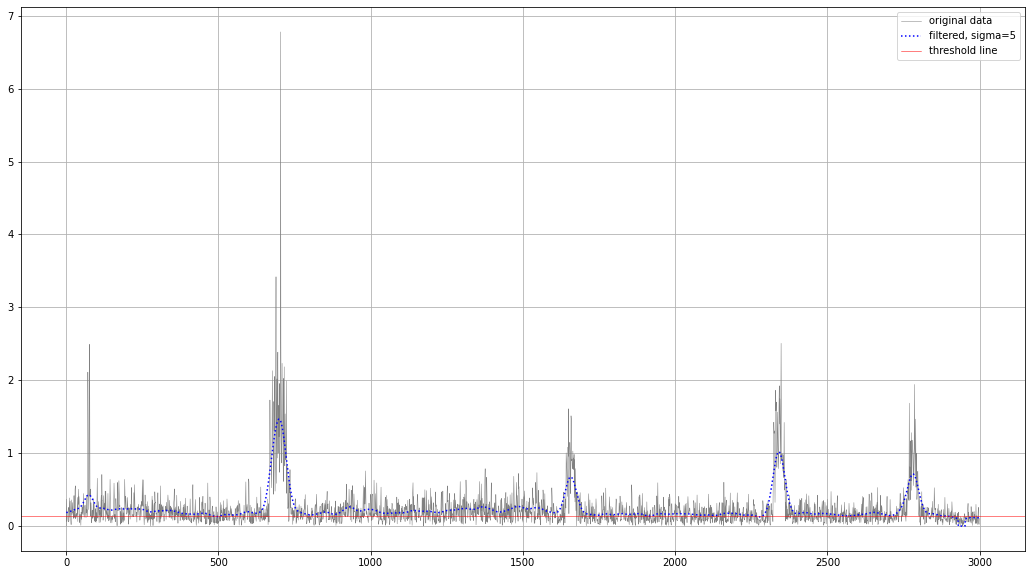

Threshold:  0.13838435991012138
Number of Peaks:  35


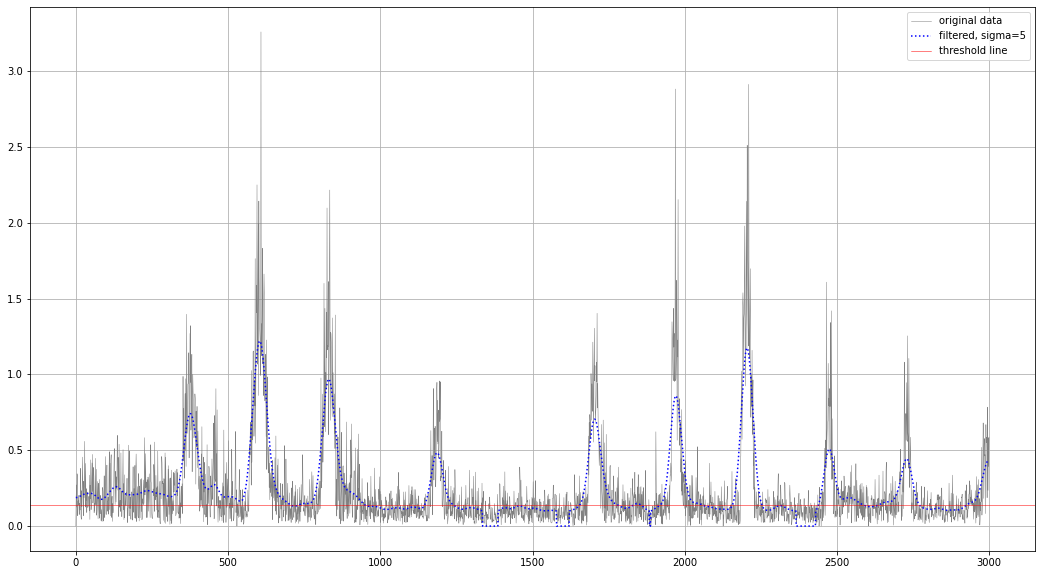

Threshold:  0.13758190329981895
Number of Peaks:  17


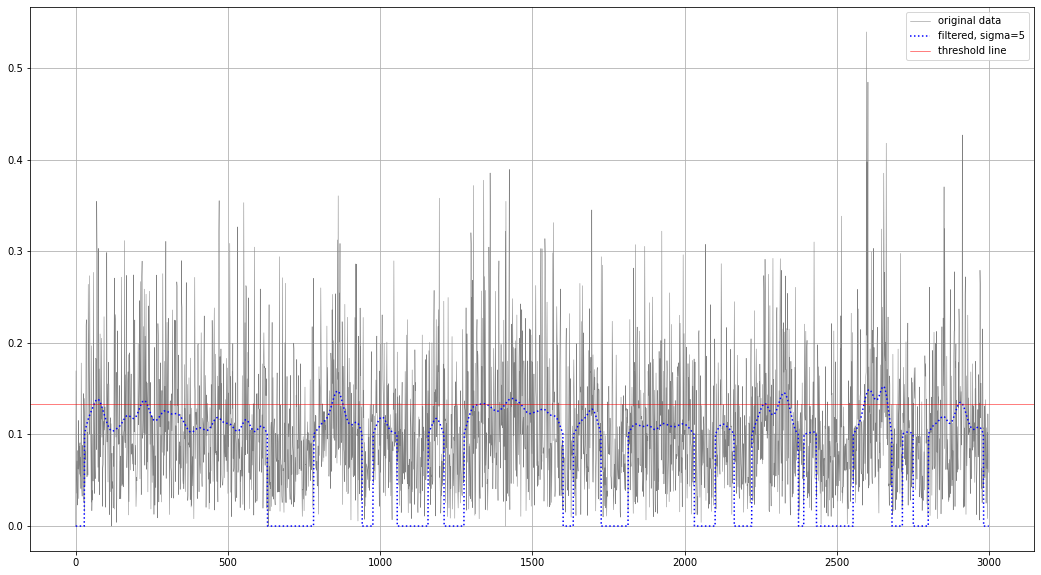

Threshold:  0.13308172925651524
Number of Peaks:  10


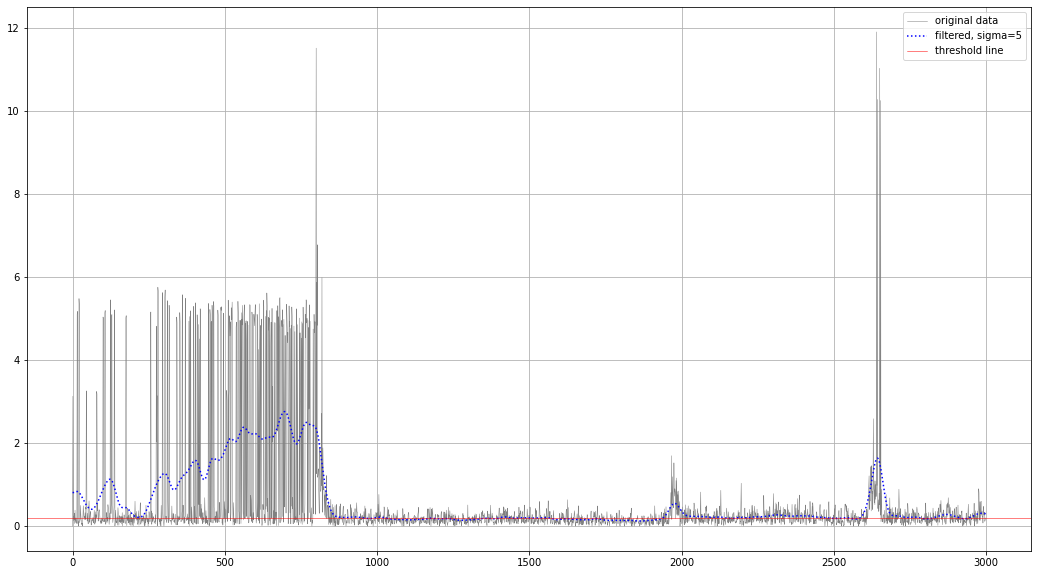

Threshold:  0.19711568550468941
Number of Peaks:  29


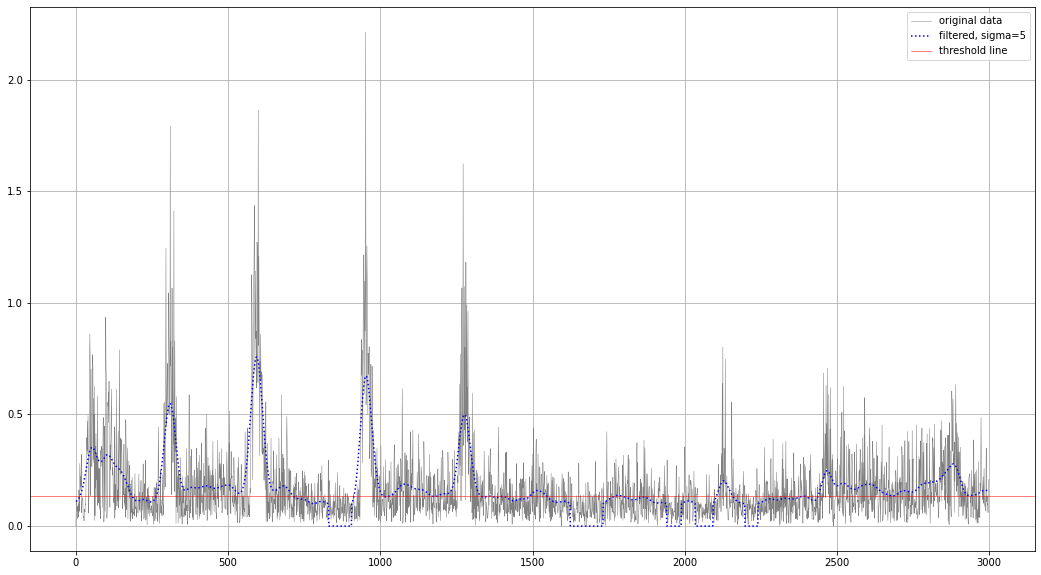

Threshold:  0.13283647388822206
Number of Peaks:  24


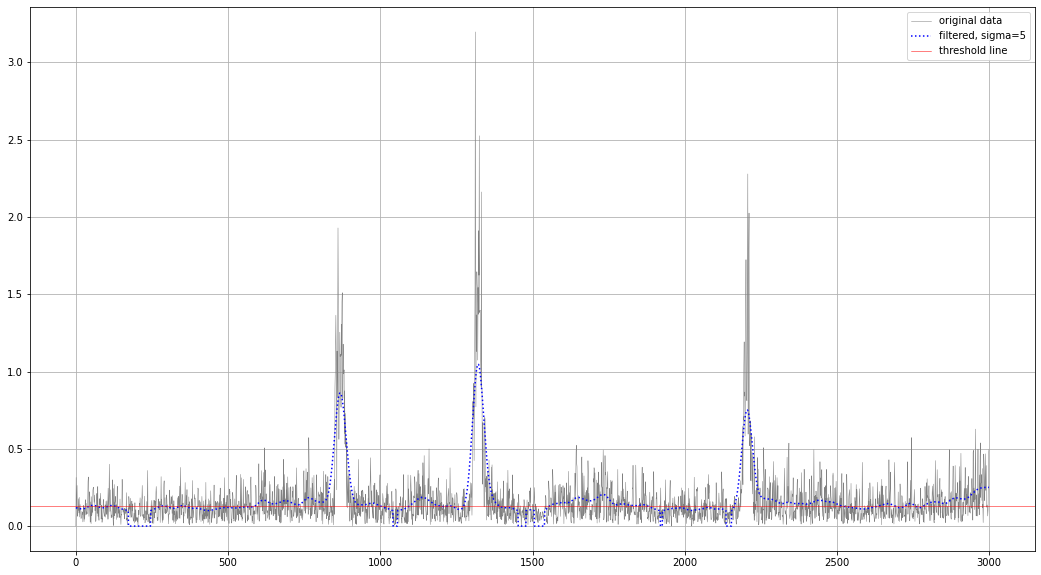

Threshold:  0.13182856097320267
Number of Peaks:  23


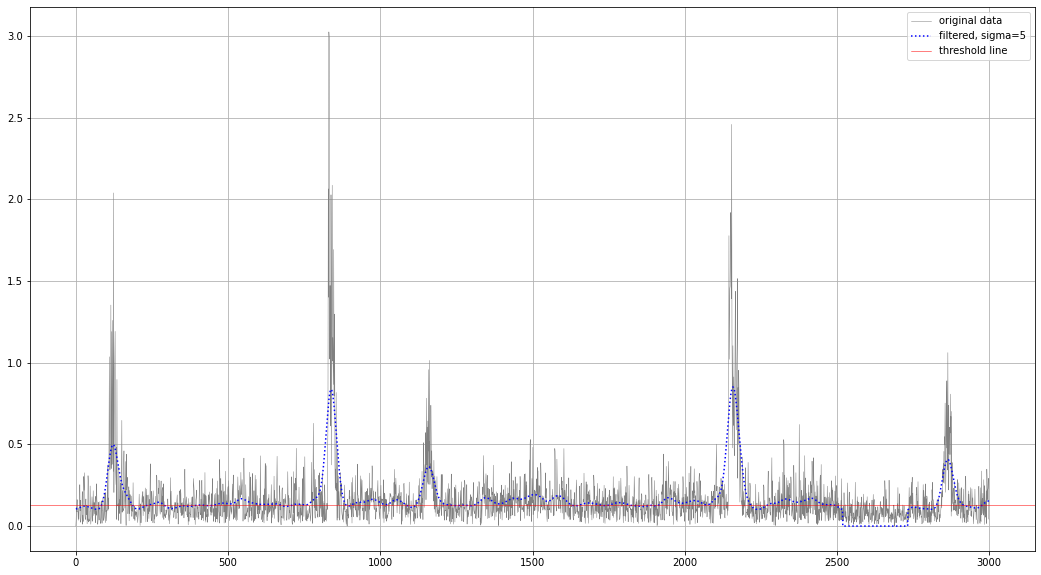

Threshold:  0.1311329092166097
Number of Peaks:  23


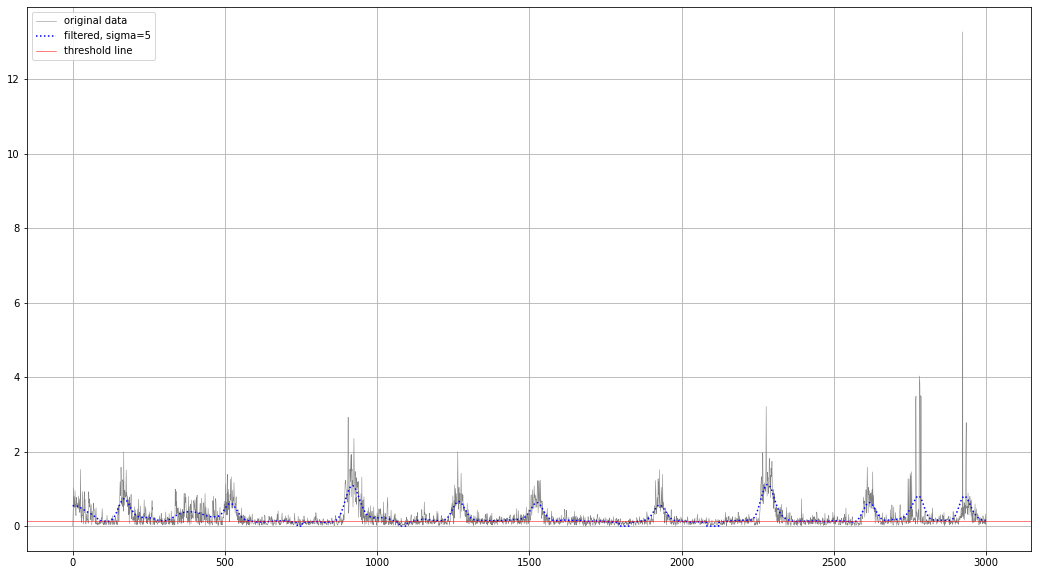

Threshold:  0.13240572829951486
Number of Peaks:  25


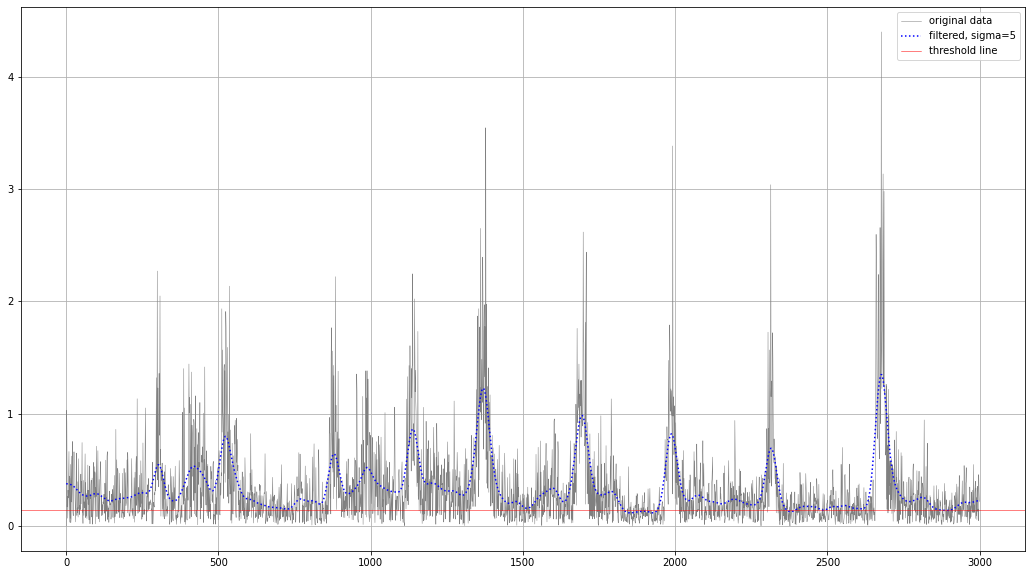

Threshold:  0.1426244234766462
Number of Peaks:  27


In [265]:
all_contrasts=[LC_01, LC_1, LC_2, LC_3, LC_5, LC_7, LC_10, RC_01, RC_1, RC_2, RC_3, RC_5, RC_7, RC_10]
for contrast in all_contrasts:    
    fish_distance = contrast[:,-1]
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)

    t = np.arange(0, 3000, 1)
    sig = fish_distance #composite signal
    sig_clean = sig #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()

    widths = np.arange(1, 3000)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    fig, ax = plt.subplots(1,1,figsize=(18,10))
    ax.plot(cwtmatr[0,:])
    ax.plot(sig,'k',lw=1)
    ax.matshow(cwtmatr.real, extent=[1, 3000, 0, 6], cmap='seismic', aspect='auto',interpolation='nearest')
    plt.show()
    
    t = np.arange(0, 3000, 1)
    cwt_sig = cwtmatr[25,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()

    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

    ## Filter out noise
    threshold = 1
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)

    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=1:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2

    fig, ax = plt.subplots(1,1,figsize=(18,10))
    ax.plot(sig,'k',lw=1,label='original data')
    ax.plot(cwt_sig, 'gray', lw=0.5, label='cwt data')
    ax.plot(fft_gauss, '-', color='b',label='fft_gauss')
    ax.axhline(y=1, color='r', linestyle='-',lw=0.5,label='threshold line')
    ax.legend()
    ax.grid()
    plt.show()

    peaks = find_peaks(fft_gauss,height=1)

    print('Number of Peaks: ',len(peaks[0]))